In [16]:
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import multiprocess
import sys
import os
import ast
from numpy import linalg 

In [17]:

def create_XFR(n, t = 2,k = 2):
    if n ==2:
        t = 1

    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        if i <= t:
            F = F + vals
    
    R = {}
    react_count = 1
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                if cand2 != cand1:
                    #print(list(R.values()))
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    
                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
                    
                    if [[X[i], X[j]], [cand2]] not in list(R.values()):
                        R[react_count] = [[X[j], X[i]], [cand2]]
                        react_count +=1
                    
                    if [[cand2],[X[i], X[j]]] not in list(R.values()):
                        R[react_count] = [[cand2],[X[j], X[i]]]
                        react_count +=1
                else:
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    

                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
    
    return(X,F, R)

In [18]:
def create_catalysts (X, react_count, p):
    C = {}
    for i in X:
        for j in range(1, react_count):
            if np.random.random(1)[0] < p:
                if j%2 == 1:
                    k = 1
                else:
                    k = -1

                if j in C.keys():
                    if i not in C[j]:
                        C[j].append(i)
                else:
                    C[j]= [i]

                if j+k in C.keys():
                    if i not in C[j+k]:
                        C[j+k].append(i)
                else:
                    C[j+k]= [i]
                
    return (C)

In [19]:
def closure(F, R):
    no_change = 0
    X = list(F)

    while no_change !=1:
        no_change = 1

        for i in list(R.values()):
            sufficient = 1
            for j in i[0]:
                if j not in X:
                    sufficient = 0
            if sufficient == 1:
                for k in i[1]:
                    if k not in X:
                        X.append(k)
                        no_change = 0
    return(X)

In [20]:

def Rsupp (R):
    supp = []
    for i in list(R.values()):
        cands = i[0] + i[1]
        for j in cands:
            if j not in supp:
                supp.append(j)
    return(supp)

def reduceR(R, C):

    catalyzed = list(C.keys())
    uncat_R = list(set(R.keys()) - set(catalyzed))


    for i in uncat_R:
        del R[i]
    
    
    no_change = 0
    while no_change != 1:
        no_change = 1

        suppR= Rsupp(R)
        Rs = list(C.keys())

        for i in Rs:
            for j in C[i]:
                if j not in suppR:
                    C[i] = C[i].remove(j)
                
                if not C[i]:
                    # print("DELETE")
                    del C[i]
                    if i in R:
                        del R[i]
                    no_change = 0
                    #break
         
    return(R,C)

def reduceToF(F, R):
    W = closure(F,R)
    r_num= list(R.keys())
    
    for i in r_num:
        remove = 0
        for j in R[i][0]:
            if j not in W:
                remove = 1
                break
        if remove == 1:
            del R[i]

    
    return R

In [219]:
# CORRECT RAF??
def RAF(X,F,R,C):
    X_prev = X.copy()
    R_prev = copy.deepcopy(R)
    C_prev = copy.deepcopy(C)

    i = 0 
    change = 0
    while change != 1:
        R_new, C_new = reduceR(copy.deepcopy(R_prev), copy.deepcopy(C_prev))
        X_new = closure(F,R_new)
        R_new = reduceToF(F,R_new)
        i= i+1

        if R_new != False and X_new != False:
            if X_prev == X_new and R_prev == R_new:
                change = 1
            else:
                R_prev = copy.deepcopy(R_new)
                X_prev = X_new.copy()
                C_prev= copy.deepcopy(C_new)
        else:
            break
    
    if not R:
        return 0 #, X_new
    
    else:
        #print(X_old)
        #print(R_old)
        #graph(X_old, F, R_old,C_old)
        return 1 #, X_new


In [22]:
def graph (X, F, R, C):
    DG = nx.MultiDiGraph()

    for node in X:
   
        if node in F:
            DG.add_node(node, ncolor = "orange")
           
        else:
            DG.add_node(node, ncolor = 'lawngreen')
        

    for node in R: 
        text = "R{}".format(node)
        DG.add_node(text, ncolor = 'salmon')
    

        for i in range(len(R[node][0])):
            DG.add_edge(R[node][0][i], text, color = "steelblue")
        
        for i in range(len(R[node][1])):
            DG.add_edge(text,R[node][1][i], color ="steelblue")
  

    for j in C:
        for k in C[j]:
            if k in X and j in list(R.keys()):
                text = "R{}".format(j)
                DG.add_edge(k, text, color ="fuchsia")




    edge_colors = []

    for (u,v,attrib_dict) in list(DG.edges.data()):
        edge_colors.append(attrib_dict['color'])
    
    node_colors = list(nx.get_node_attributes(DG, "ncolor").values())
    
 


    nx.draw(DG, node_color= node_colors, edge_color = edge_colors, with_labels=True, font_weight='bold', node_size = 750, pos=nx.circular_layout(DG), connectionstyle='arc3, rad = 0.1')
    
    plt.show()

In [41]:
n = 3
t = 2
f = 0.1

X,F,R = create_XFR(n, t)
p = f/len(R)

C = create_catalysts(X, len(R),p)

print(len(X)*len(R))

504


In [44]:
X

['A',
 'B',
 'AA',
 'AB',
 'BA',
 'BB',
 'AAA',
 'AAB',
 'ABA',
 'ABB',
 'BAA',
 'BAB',
 'BBA',
 'BBB']

In [120]:
len_r
counts = {2: 0.35, 3: 0.25, 4: 0.45, 5: 1.12, 6:1.3, 7:1.4, 8:1.4, 10:1.4}

In [125]:
0.5**(1/240)

0.9971160533345892

In [126]:
y1 = []
for i in range(3,10):
   Rn = len_r[i+1]
   y1.append( Rn*(1 - 0.5**(1/240)))
   #print("{}: {}".format(i , f))

In [127]:
y1

[0.36914517317258344,
 1.0843639461944639,
 2.8954824520724514,
 7.290617170158523,
 17.580538872344285,
 41.12507944875812,
 94.21276966564028]

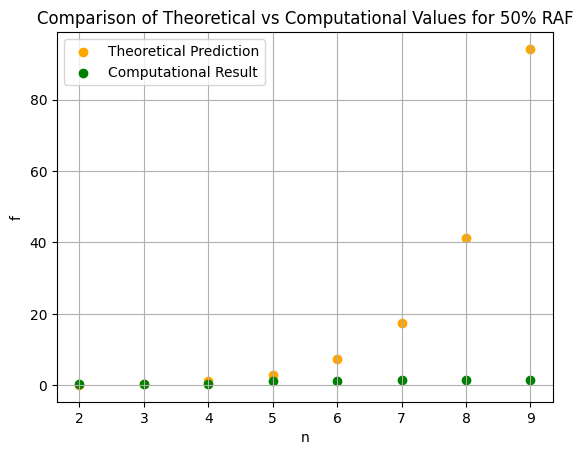

In [123]:
x = range(3,10)
y1 
y2 = [counts[x] for x in counts]

plt.scatter(x, y1, label='Theoretical Prediction', color='orange')
plt.scatter(x, y2, label='Computational Result', color='green')

# Add labels and a legend
plt.xlabel('n')
plt.ylabel('f')
plt.legend()

# Show the plot
plt.title('Comparison of Theoretical vs Computational Values for 50% RAF')
plt.grid(True)
plt.show()


In [45]:
F

['A', 'B', 'AA', 'AB', 'BA', 'BB']

In [46]:
[i for i in X if i not in F]

['AAA', 'AAB', 'ABA', 'ABB', 'BAA', 'BAB', 'BBA', 'BBB']

In [61]:
list(first_order.keys())

['AAA',
 'AAB',
 'ABA',
 'ABB',
 'BAA',
 'BAB',
 'BBA',
 'BBB',
 'AAAA',
 'AAAB',
 'AABA',
 'AABB',
 'ABAA',
 'ABAB',
 'ABBA',
 'ABBB',
 'BAAA',
 'BAAB',
 'BABA',
 'BABB',
 'BBAA',
 'BBAB',
 'BBBA',
 'BBBB']

{4: ['B'], 3: ['B']}


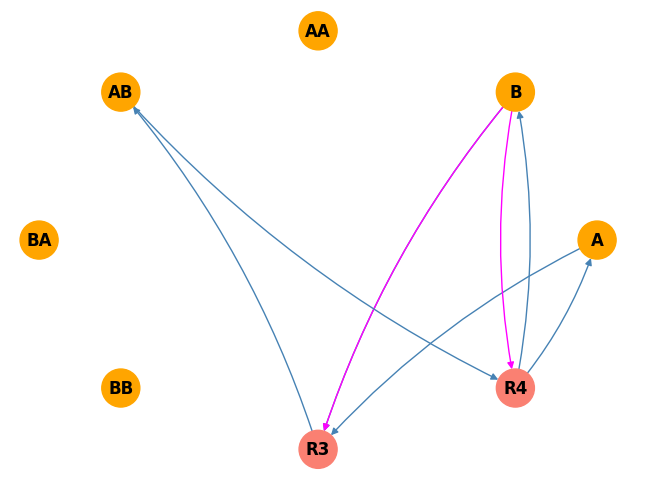

1
7
--


In [92]:
n = 4
t = 2
f = 0.2
N = 20

raf_count = 0
non_first = 0




for i in range(N):
    X,F,R = create_XFR(n, t)
    first_order = {}
    for i in F:
        for j in F:
            add = i + j
            if add not in F:
                if add not in first_order:
                    first_order[add] = 1
                else:
                    first_order[add] +=1


    p = f/len(R)
    #print(p)
    C = create_catalysts(X, len(R),p)
    raf, X_old = RAF(X,F,R,C)
    if raf == 1:
        raf_count +=1
        gen = [i for i in X_old if i not in F]
        #print(gen)
        if len(gen) == 0:
            first_order_gen = [j for j in gen if j in list(first_order.keys())]
            if len(first_order_gen) == 0:
                print(C)
                graph(X_old, F,R,C)
                non_first +=1

print(non_first)
print(raf_count)
print("--")
        
        




In [211]:
X,F,R = create_XFR(5)

In [162]:
F

['A', 'B', 'AA', 'AB', 'BA', 'BB']

In [163]:
first_order = {}
for i in F:
    for j in F:
        add = i + j
        if add not in F:
            if add not in first_order:
                first_order[add] = 1
            else:
                first_order[add] +=1
first_order.keys()

dict_keys(['AAA', 'AAB', 'ABA', 'ABB', 'BAA', 'BAB', 'BBA', 'BBB', 'AAAA', 'AAAB', 'AABA', 'AABB', 'ABAA', 'ABAB', 'ABBA', 'ABBB', 'BAAA', 'BAAB', 'BABA', 'BABB', 'BBAA', 'BBAB', 'BBBA', 'BBBB'])

In [164]:
internal = []
FO =[]
for reaction in R:
    if reaction % 2 == 1:
        if R[reaction][1][0] in F:
            internal.append(reaction)
            internal.append(reaction +1)
        elif R[reaction][1][0] in first_order.keys():
            FO.append(reaction)
            FO.append(reaction +1)


In [165]:
internal

[1, 2, 3, 4, 5, 6, 113, 114]

In [166]:
len(FO)

120

In [159]:
len(internal) + len(FO)

128

In [ ]:
R

In [ ]:
C = create_catalysts(X, len(R), 0.3)
C

In [226]:

file1 = open("Data/Dict-Matrix-5-1.12-Non-RAF.txt", 'r')
Lines = file1.readlines()
    
non_raf = [ast.literal_eval(line) for line in Lines]

In [236]:
output= []
X,F,R = create_XFR(5)
for c in non_raf:
    if RAF(X,F,R,c)[0] == 0:
        output.append(new_RAF(F,R,c))

In [237]:
output

[]

In [229]:
non_raf[1]

{90: ['B'],
 89: ['B'],
 81: ['AA'],
 82: ['AA'],
 268: ['AA'],
 267: ['AA'],
 95: ['BA'],
 96: ['BA'],
 87: ['BB', 'AABA'],
 88: ['BB', 'AABA'],
 351: ['AAA'],
 352: ['AAA'],
 310: ['AAAA'],
 309: ['AAAA'],
 316: ['AAAB'],
 315: ['AAAB'],
 371: ['AABA'],
 372: ['AABA'],
 77: ['ABAA'],
 78: ['ABAA'],
 190: ['ABAA'],
 189: ['ABAA'],
 322: ['ABAA'],
 321: ['ABAA'],
 18: ['ABAB', 'BABBA'],
 17: ['ABAB', 'BABBA'],
 142: ['ABAB'],
 141: ['ABAB'],
 218: ['ABBA'],
 217: ['ABBA'],
 65: ['ABBB'],
 66: ['ABBB'],
 191: ['ABBB'],
 192: ['ABBB'],
 92: ['BAAA'],
 91: ['BAAA'],
 124: ['BAAA'],
 123: ['BAAA'],
 287: ['BAAA'],
 288: ['BAAA'],
 14: ['BAAB'],
 13: ['BAAB'],
 214: ['BAAB'],
 213: ['BAAB'],
 230: ['BAAB'],
 229: ['BAAB'],
 339: ['BAAB'],
 340: ['BAAB'],
 364: ['BAAB'],
 363: ['BAAB'],
 266: ['BABA', 'BAAAB'],
 265: ['BABA', 'BAAAB'],
 276: ['BABA', 'BABBA'],
 275: ['BABA', 'BABBA'],
 220: ['BABB'],
 219: ['BABB'],
 331: ['BABB', 'BBBB'],
 332: ['BABB', 'BBBB'],
 23: ['BBAA'],
 24: ['BBAA']

In [233]:
non_raf[1]

{90: ['B'],
 89: ['B'],
 81: ['AA'],
 82: ['AA'],
 268: ['AA'],
 267: ['AA'],
 95: ['BA'],
 96: ['BA'],
 87: ['BB', 'AABA'],
 88: ['BB', 'AABA'],
 351: ['AAA'],
 352: ['AAA'],
 310: ['AAAA'],
 309: ['AAAA'],
 316: ['AAAB'],
 315: ['AAAB'],
 371: ['AABA'],
 372: ['AABA'],
 77: ['ABAA'],
 78: ['ABAA'],
 190: ['ABAA'],
 189: ['ABAA'],
 322: ['ABAA'],
 321: ['ABAA'],
 18: ['ABAB', 'BABBA'],
 17: ['ABAB', 'BABBA'],
 142: ['ABAB'],
 141: ['ABAB'],
 218: ['ABBA'],
 217: ['ABBA'],
 65: ['ABBB'],
 66: ['ABBB'],
 191: ['ABBB'],
 192: ['ABBB'],
 92: ['BAAA'],
 91: ['BAAA'],
 124: ['BAAA'],
 123: ['BAAA'],
 287: ['BAAA'],
 288: ['BAAA'],
 14: ['BAAB'],
 13: ['BAAB'],
 214: ['BAAB'],
 213: ['BAAB'],
 230: ['BAAB'],
 229: ['BAAB'],
 339: ['BAAB'],
 340: ['BAAB'],
 364: ['BAAB'],
 363: ['BAAB'],
 266: ['BABA', 'BAAAB'],
 265: ['BABA', 'BAAAB'],
 276: ['BABA', 'BABBA'],
 275: ['BABA', 'BABBA'],
 220: ['BABB'],
 219: ['BABB'],
 331: ['BABB', 'BBBB'],
 332: ['BABB', 'BBBB'],
 23: ['BBAA'],
 24: ['BBAA']

In [234]:
RAF(X,F,R,non_raf[1])

(1, ['A', 'B', 'AA', 'AB', 'BA', 'BB'])

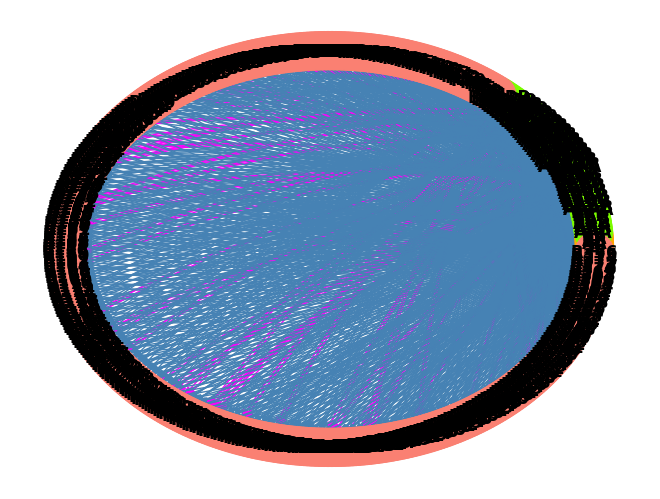

In [235]:
graph(X,F,R,non_raf[1])

In [231]:
new_RAF(F,R,non_raf[1])

267
268


2

In [189]:
non_raf[1]

{}

In [186]:
R[267]

[['AB', 'BA'], ['ABBA']]

In [184]:
def new_RAF (F,R,C):

    first_order = {}
    for i in F:
        for j in F:
            add = i + j
            if add not in F:
                if add not in first_order:
                    first_order[add] = 1
                else:
                    first_order[add] +=1

    react_list = []
    for reaction in R:
        if reaction % 2 == 1:
            if R[reaction][1][0] in F:
                react_list.append(reaction)
                react_list.append(reaction +1)
            elif R[reaction][1][0] in first_order.keys():
                react_list.append(reaction)
                react_list.append(reaction +1)

    count = 0
    
    for reaction in react_list:
        if reaction in C:
            if len(list(set(C[reaction]) & set(F))) != 0:
                print(reaction)
                count += len(list(set(C[reaction]) & set(F))) 
    
    return count
            

    

In [129]:
len(X)

30

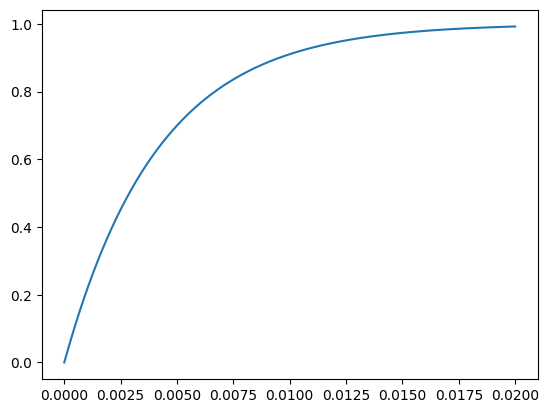

In [136]:
ps = np.linspace(0,0.02, 10000)
pRAF = [1- (1- x)**240 for x in ps]

plt.plot(ps, pRAF)

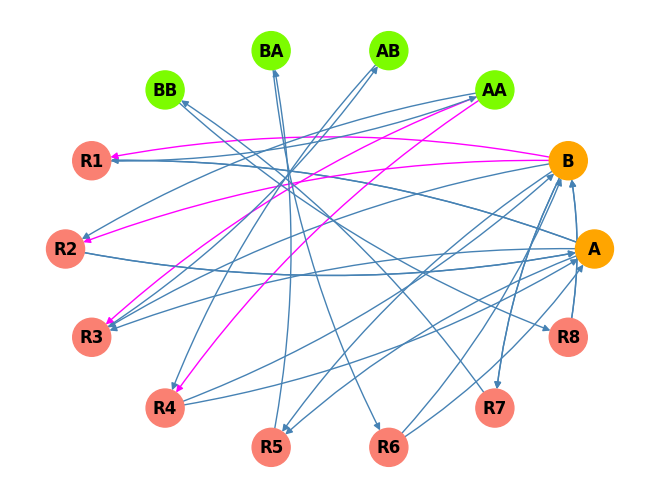

In [108]:
n = 2
t = 1
f = 0.3
p = f/len(R)

X,F,R = create_XFR(n, t)
C = create_catalysts(X, len(R),p)

graph(X,F,R,C)

In [94]:
def len_R (n, k = 2):
    # Set of Molecules
    X = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        
    #print(X)
    #print(F)

    # Reaction (pair of molecules)
    R = {}
    react_count = 1
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                if cand2 != cand1:
                    #print(list(R.values()))
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    
                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
                    
                    if [[X[i], X[j]], [cand2]] not in list(R.values()):
                        R[react_count] = [[X[j], X[i]], [cand2]]
                        react_count +=1
                    
                    if [[cand2],[X[i], X[j]]] not in list(R.values()):
                        R[react_count] = [[cand2],[X[j], X[i]]]
                        react_count +=1
                else:
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    

                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
    return react_count -1

len_r = {2: 8, 3:36, 4: 128, 5: 376, 6: 1004, 7:2528, 8 : 6096, 9:14260, 10:32668}



In [95]:
def theo(f,n):
    if n in len_r:
        R = len_r[n]
    else:
        R = len_R(n)
        len_r[_n] = R
    return 1 - (1 - f/R)**192 - (1 - f/R)**48

In [97]:
theo(1.5,10)

-0.9890209642061595

In [91]:
RAF(X,F,R,C)

(0, ['A', 'B', 'AA', 'AB', 'BA', 'BB'])

In [30]:
F
first_order = {}
for i in F:
    for j in F:
        add = i + j
        if add not in F:
            if add not in first_order:
                first_order[add] = 1
            else:
                first_order[add] +=1

print(first_order)

{'AAA': 2, 'AAB': 2, 'ABA': 2, 'ABB': 2, 'BAA': 2, 'BAB': 2, 'BBA': 2, 'BBB': 2, 'AAAA': 1, 'AAAB': 1, 'AABA': 1, 'AABB': 1, 'ABAA': 1, 'ABAB': 1, 'ABBA': 1, 'ABBB': 1, 'BAAA': 1, 'BAAB': 1, 'BABA': 1, 'BABB': 1, 'BBAA': 1, 'BBAB': 1, 'BBBA': 1, 'BBBB': 1}


In [31]:
len(first_order)

24

In [48]:
list(first_order.keys())

['AAA',
 'AAB',
 'ABA',
 'ABB',
 'BAA',
 'BAB',
 'BBA',
 'BBB',
 'AAAA',
 'AAAB',
 'AABA',
 'AABB',
 'ABAA',
 'ABAB',
 'ABBA',
 'ABBB',
 'BAAA',
 'BAAB',
 'BABA',
 'BABB',
 'BBAA',
 'BBAB',
 'BBBA',
 'BBBB']

In [35]:
sum(first_order.values())

32

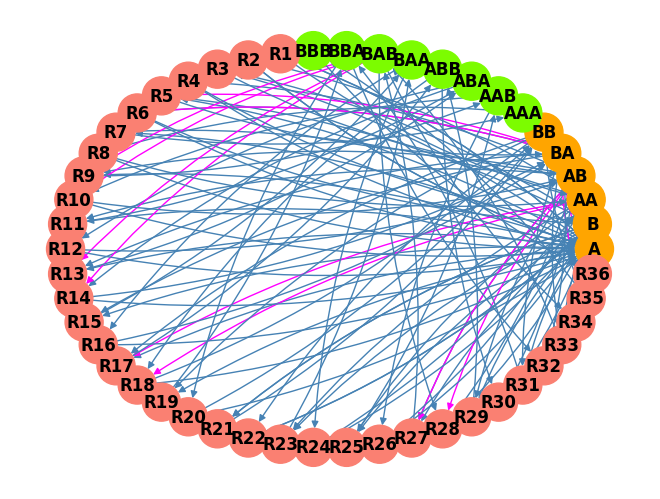

In [26]:
graph(X,F,R,C)

In [98]:
RAF(X,F,R,C)

(0, ['A', 'B', 'AA', 'AB', 'BA', 'BB'])

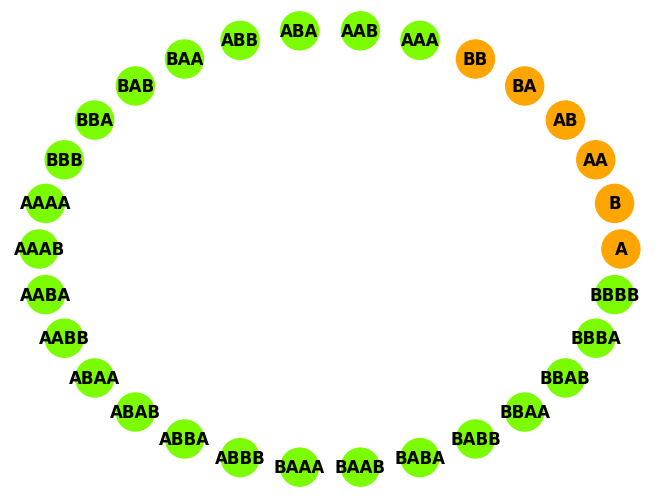

In [100]:
graph(X,F,R,C)

In [10]:
X_dict = {}
for i in range(len(X)):
    X_dict[X[i]] = i
X_dict

{'A': 0, 'B': 1, 'AA': 2, 'AB': 3, 'BA': 4, 'BB': 5}

In [8]:
len(X) * len(R)

NameError: name 'X' is not defined

In [ ]:
M1 = np.zeros(len(X) * len(R))
M1= M1.reshape((len(X), len(R)))
M1

M2 = np.zeros(len(X) * len(R))
M2= M2.reshape((len(X), len(R)))
M2

In [6]:
import pickle

file = "Data/Dict-Matrix-2-0.25-RAF.pkl"
with open(file, "rb") as f_dict:
    yeet =pickle.load(f_dict)

In [7]:
yeet

{5: ['A'], 6: ['A'], 2: ['BB'], 1: ['BB']}

In [12]:

for reaction in C:
    for c in C[reaction]:
        i = X_dict[c]
        j = reaction -1
        #print(i)
        #print(j)
        #print("")
        M1[i,j] = 1

NameError: name 'M1' is not defined

In [61]:
C = create_catalysts(X, len(R),p)
for reaction in C:
    for c in C[reaction]:
        i = X_dict[c]
        j = reaction -1
        #print(i)
        #print(j)
        #print("")
        M2[i,j] = 1


In [63]:
linalg.norm(M1 - M2 , "fro")

4.69041575982343

In [ ]:
M2

In [65]:
linalg.norm(M1 - M2 , "nuc")

11.180928923711832

In [21]:
mat = np.load("Data/Matrix-2-0.2-RAF.npy")
#mat.columns = ["n", "f", "matrix"]
mat.shape

(7, 6, 8)

In [22]:
N

7

In [16]:
mat

array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0.,

In [12]:
nuc_norms= []
fro_norms = []
for i in range(N):
    for j in range(N):
        if i != j:
            nuc_norms.append(linalg.norm(mat[i] - mat[j] , "nuc"))
            fro_norms.append(linalg.norm(mat[i] - mat[j] , "fro"))


In [ ]:
#

#### Nuclear Norm

In [13]:
print(np.mean(nuc_norms))
print(np.std(nuc_norms))
print(np.max(nuc_norms))
print(np.min(nuc_norms))


2.718767044858916
1.1618152828254045
4.576491222541474
0.0


In [14]:
print(np.mean(fro_norms))
print(np.std(fro_norms))
print(np.max(fro_norms))
print(np.min(fro_norms))


2.0038666341192375
0.6045418873957514
2.8284271247461903
0.0


In [26]:
ind_norms = []
for i in range(N):
    ind_norms.append(linalg.norm(mat[i], "fro"))



In [27]:
np.mean(ind_norms)

1.6652648927846259

In [19]:
pd.read_csv("Data/RAF_fro_norms.csv")

,Unnamed: 0,n,f,N,Mean,Std,Min,Max
0,0,2.0,0.20,7,2.003867,0.604542,0.000000,2.828427
1,1,2.0,0.35,45,2.487734,0.705726,0.000000,4.242641
2,2,3.0,0.25,47,2.904011,0.643491,0.000000,5.656854
3,3,3.0,0.30,6,3.490691,0.694079,2.449490,4.690416
4,4,4.0,0.40,3,3.495094,1.057191,2.000000,4.242641
5,5,4.0,0.45,41,4.081073,1.192852,1.414214,7.348469
6,6,5.0,1.12,47,8.265323,3.401975,2.449490,16.248077
7,7,6.0,1.30,43,15.782686,5.703339,2.828427,24.248711


In [20]:
pd.read_csv("Data/Non-RAF_fro_norms.csv")

,Unnamed: 0,n,f,N,Mean,Std,Min,Max
0,0,2.0,0.20,3,0.0,0.0,0.0,0.0
1,1,2.0,0.35,55,0.0,0.0,0.0,0.0
2,2,3.0,0.25,53,0.0,0.0,0.0,0.0
3,3,3.0,0.30,4,0.0,0.0,0.0,0.0
4,4,4.0,0.40,7,0.0,0.0,0.0,0.0
5,5,4.0,0.45,59,0.0,0.0,0.0,0.0
6,6,5.0,1.12,53,0.0,0.0,0.0,0.0
7,7,6.0,1.30,57,0.0,0.0,0.0,0.0
